In [1]:
"""
FRAMEWORK DE DISSERTAÇÃO (VERSÃO FINAL COMPLETA)
Título: Reconstrução de Potenciais e Evolução Temporal na Equação de Schrödinger
        a partir de Dados Esparsos usando Deep Learning
Autor: [Seu Nome]
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import os
import sys
import subprocess

# --- 1. INSTALAÇÃO DE DEPENDÊNCIAS (Blindagem) ---
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    from pyDOE import lhs
except ImportError:
    install('pyDOE')
    from pyDOE import lhs

# --- 2. CONFIGURAÇÕES E SEMENTES ---
# Sementes fixas para garantir que o resultado seja idêntico na Banca
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🔧 Ambiente Configurado: {device}")
if not os.path.exists('resultados_dissertacao'):
    os.makedirs('resultados_dissertacao')

# --- 3. O UNIVERSO FÍSICO (GROUND TRUTH) ---
class QuantumUniverse:
    """Gera a solução analítica exata do Sóliton (NLSE)"""
    def __init__(self):
        self.beta_real = 1.0

    def exact_solution(self, x, t):
        # Solução clássica do Sóliton brilhante
        return (1.0 / np.cosh(x)) * np.exp(1j * 0.5 * t)

    def generate_data(self, n_space=256, n_time=100):
        x = np.linspace(-5, 5, n_space)
        t = np.linspace(0, np.pi/2, n_time)
        X, T = np.meshgrid(x, t)
        psi = self.exact_solution(X, T)
        return X, T, psi

# --- 4. A ARQUITETURA PINN ---
class PhysicsInformedNN(nn.Module):
    def __init__(self, layers):
        super(PhysicsInformedNN, self).__init__()
        # O parâmetro físico oculto que queremos descobrir (Inicia em 0.0)
        self.beta_est = nn.Parameter(torch.tensor([0.0], dtype=torch.float32).to(device))

        # Rede Neural Densa (MLP)
        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))

        # Inicialização de Xavier (Crucial para convergir)
        for i in range(len(self.linears)):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x, t):
        a = torch.cat([x, t], dim=1)
        # Tanh é a melhor ativação para física de ondas contínuas
        for i in range(len(self.linears) - 2):
            z = self.linears[i](a)
            a = torch.tanh(z)
        return self.linears[-1](a)

    def predict(self, x, t):
        self.eval()
        output = self.forward(x, t)
        return output[:, 0:1].detach().cpu().numpy(), output[:, 1:2].detach().cpu().numpy()

# --- 5. O TREINADOR (COM FÍSICA EMBUTIDA) ---
class PINNTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        # Histórico para os gráficos da dissertação
        self.history = {'loss': [], 'loss_data': [], 'loss_phys': [], 'beta': []}
        self.beta_real = 1.0

    def physics_residue(self, x, t):
        """Calcula o erro da Equação de Schrödinger (Autograd)"""
        x.requires_grad = True
        t.requires_grad = True

        psi = self.model(x, t)
        u, v = psi[:, 0:1], psi[:, 1:2]

        # Derivadas parciais automáticas
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]

        # A Equação NLSE: i*ut + 0.5*uxx + beta*|u|^2*u = 0
        param = self.model.beta_est
        density = u**2 + v**2

        f_u = u_t + 0.5 * v_xx + param * density * v
        f_v = v_t - 0.5 * u_xx - param * density * u
        return f_u, f_v

    def train(self, epochs, data):
        x_u, t_u, u_u, v_u, x_f, t_f = data
        print(f"🚀 Iniciando Treinamento ({epochs} épocas)...")
        start_time = time.time()

        for epoch in range(epochs):
            self.optimizer.zero_grad()

            # 1. Loss de Dados (MSE nos pontos ruidosos)
            pred = self.model(x_u, t_u)
            loss_data = torch.mean((x_u - x_u)**2) + torch.mean((pred[:,0:1] - u_u)**2 + (pred[:,1:2] - v_u)**2)

            # 2. Loss de Física (Resíduo nos pontos de colocação)
            f_u, f_v = self.physics_residue(x_f, t_f)
            loss_phys = torch.mean(f_u**2 + f_v**2)

            loss = loss_data + loss_phys
            loss.backward()
            self.optimizer.step()

            # Salvar histórico
            self.history['loss'].append(loss.item())
            self.history['loss_data'].append(loss_data.item())
            self.history['loss_phys'].append(loss_phys.item())
            self.history['beta'].append(self.model.beta_est.item())

            if epoch % 1000 == 0:
                err = abs(self.model.beta_est.item() - 1.0) * 100
                print(f"Epoca {epoch}: Loss Total: {loss.item():.5f} | Beta: {self.model.beta_est.item():.4f} (Erro: {err:.2f}%)")

        print(f"✅ Treino Concluído em {time.time()-start_time:.1f}s")

# --- 6. PREPARAÇÃO DE DADOS (ESTRESSE: 20% RUÍDO) ---
print("🎲 Gerando Dados Sintéticos com 20% de Ruído...")
universe = QuantumUniverse()
X, T, Psi = universe.generate_data()
x_flat, t_flat = X.flatten()[:, None], T.flatten()[:, None]
u_flat, v_flat = np.real(Psi).flatten()[:, None], np.imag(Psi).flatten()[:, None]

# Design Experimental: Poucos Dados (500) + Muito Ruído (20%)
N_u, N_f = 500, 10000
noise = 0.20

idx = np.random.choice(x_flat.shape[0], N_u, replace=False)
x_train = x_flat[idx, :]
t_train = t_flat[idx, :]
u_train = u_flat[idx, :] + noise * np.std(u_flat) * np.random.randn(N_u, 1)
v_train = v_flat[idx, :] + noise * np.std(v_flat) * np.random.randn(N_u, 1)

# Collocation Points (LHS)
lb, ub = np.array([-5.0, 0.0]), np.array([5.0, np.pi/2])
X_f = lb + (ub-lb) * lhs(2, N_f)
x_f, t_f = X_f[:, 0:1], X_f[:, 1:2]

# Tensores GPU
d = lambda a: torch.tensor(a, dtype=torch.float32).to(device)
data = (d(x_train), d(t_train), d(u_train), d(v_train), d(x_f), d(t_f))

# --- 7. RODANDO O MODELO ---
model = PhysicsInformedNN([2, 50, 50, 50, 50, 2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = PINNTrainer(model, optimizer)
trainer.train(5000, data)

# --- 8. GERANDO AS FIGURAS DA DISSERTAÇÃO ---
print("📊 Gerando Gráficos para a Dissertação...")

# FIGURA 1: Descoberta do Parâmetro (Beta)
plt

🔧 Ambiente Configurado: cuda
🎲 Gerando Dados Sintéticos com 20% de Ruído...
🚀 Iniciando Treinamento (5000 épocas)...
Epoca 0: Loss Total: 0.89487 | Beta: 0.0010 (Erro: 99.90%)
Epoca 1000: Loss Total: 0.00460 | Beta: 0.8203 (Erro: 17.97%)
Epoca 2000: Loss Total: 0.00391 | Beta: 0.9842 (Erro: 1.58%)
Epoca 3000: Loss Total: 0.00386 | Beta: 1.0000 (Erro: 0.00%)
Epoca 4000: Loss Total: 0.00388 | Beta: 1.0012 (Erro: 0.12%)
✅ Treino Concluído em 56.3s
📊 Gerando Gráficos para a Dissertação...


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

### Adição 1: Cálculo de Métricas de Erro Quantitativas

Vamos calcular o Root Mean Square Error (RMSE) e o erro relativo percentual para a magnitude da solução (amplitude) em todo o domínio de espaço-tempo. Isso fornecerá uma métrica numérica do quão bem o PINN se aproximou da verdade física.

In [2]:
print("\n--- Análise de Erro Quantitativo ---")

# Recuperando os dados completos do universo (ground truth)
universe = QuantumUniverse()
X_full_np, T_full_np, Psi_Exact_full = universe.generate_data(n_space=256, n_time=100) # Usar a mesma resolução dos dados gerados

x_full_tensor = torch.tensor(X_full_np.flatten()[:, None], dtype=torch.float32).to(device)
t_full_tensor = torch.tensor(T_full_np.flatten()[:, None], dtype=torch.float32).to(device)

# Previsão do modelo para o grid completo
model.eval() # Colocar o modelo em modo de avaliação
u_pred_full, v_pred_full = model.predict(x_full_tensor, t_full_tensor)

H_pred_full = np.sqrt(u_pred_full**2 + v_pred_full**2)
H_exact_full = np.abs(Psi_Exact_full.flatten()[:, None])

# Calcular RMSE
rmse = np.sqrt(np.mean((H_exact_full - H_pred_full)**2))
print(f"RMSE da Magnitude (Amplitude) da Solução: {rmse:.4e}")

# Calcular Erro Relativo Percentual
relative_error = np.mean(np.abs(H_exact_full - H_pred_full) / np.abs(H_exact_full)) * 100
print(f"Erro Relativo Percentual Médio da Magnitude: {relative_error:.2f}%")

# Erro no parâmetro beta
beta_final = model.beta_est.item()
beta_real = universe.beta_real # O beta real é 1.0
error_beta_abs = abs(beta_final - beta_real)
error_beta_perc = (error_beta_abs / beta_real) * 100
print(f"Parâmetro Beta Final Estimado: {beta_final:.4f} (Real: {beta_real:.1f})")
print(f"Erro Absoluto em Beta: {error_beta_abs:.4f}")
print(f"Erro Relativo Percentual em Beta: {error_beta_perc:.2f}%")


--- Análise de Erro Quantitativo ---
RMSE da Magnitude (Amplitude) da Solução: 1.1812e-02
Erro Relativo Percentual Médio da Magnitude: 16.74%
Parâmetro Beta Final Estimado: 1.0023 (Real: 1.0)
Erro Absoluto em Beta: 0.0023
Erro Relativo Percentual em Beta: 0.23%


### Adição 2: Salvamento de Resultados

É crucial salvar os modelos treinados, o histórico de treinamento e os gráficos gerados para a dissertação. Isso garante a reprodutibilidade e permite revisitar os resultados sem a necessidade de reexecutar todo o treinamento.

In [3]:
print("\n--- Salvando Resultados ---")

# Salvar o modelo treinado
model_save_path = os.path.join('resultados_dissertacao', 'pinn_nlse_model.pth')
torch.save(model.state_dict(), model_save_path)
print(f"Modelo salvo em: {model_save_path}")

# Salvar o histórico de treinamento (loss, beta)
history_save_path = os.path.join('resultados_dissertacao', 'training_history.npz')
np.savez(history_save_path, loss=trainer.history['loss'], loss_data=trainer.history['loss_data'],
          loss_phys=trainer.history['loss_phys'], beta=trainer.history['beta'])
print(f"Histórico de treinamento salvo em: {history_save_path}")

# Salvar as figuras geradas
# (Você precisaria integrar isso com o código de plotagem)
# Exemplo: plt.savefig(os.path.join('resultados_dissertacao', 'fig1_beta_discovery.png'))
# Isso deve ser feito após cada `plt.show()` ou agrupado no final.

# Exemplo de salvamento de figuras (integrar com as seções de plotagem)
# Para a Figura 1:
# plt.figure(figsize=(10, 5))
# ... (código da figura 1)
# plt.savefig(os.path.join('resultados_dissertacao', 'fig1_beta_discovery.png'))
# plt.show()

# Para a Figura 2:
# plt.figure(figsize=(10, 5))
# ... (código da figura 2)
# plt.savefig(os.path.join('resultados_dissertacao', 'fig2_loss_curves.png'))
# plt.show()

# E assim por diante para todas as figuras.


--- Salvando Resultados ---
Modelo salvo em: resultados_dissertacao/pinn_nlse_model.pth
Histórico de treinamento salvo em: resultados_dissertacao/training_history.npz


### Adição 3: Estrutura para Análise de Hipersparâmetros (Exemplo Simples)

Para uma dissertação, é valioso mostrar como diferentes configurações afetam o resultado. Aqui está um esqueleto de como você poderia testar diferentes taxas de aprendizado. Isso exigiria encapsular o treinamento em uma função e iterar sobre os parâmetros.

In [4]:
print("\n--- Exemplo de Análise de Hipersparâmetros (Taxa de Aprendizado) ---")

def run_experiment(learning_rate, epochs, data_tuple):
    print(f"Iniciando experimento com LR={learning_rate}")
    model_exp = PhysicsInformedNN([2, 50, 50, 50, 50, 2]).to(device)
    optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=learning_rate)
    trainer_exp = PINNTrainer(model_exp, optimizer_exp)
    trainer_exp.train(epochs, data_tuple)

    # Calcular RMSE e erro beta para este experimento
    # (Reutilize o código de cálculo de erro acima, adaptando para `model_exp`)
    # ...

    return trainer_exp.history['beta'][-1], trainer_exp.history['loss'][-1]

# Exemplo de loop para testar diferentes taxas de aprendizado
learning_rates_to_test = [0.0005, 0.001, 0.002]
results = {}

# Nota: Este loop vai re-treinar o modelo múltiplas vezes, pode ser demorado.
# Para a dissertação, você faria isso com mais iterações e possivelmente salvaria mais dados.
for lr in learning_rates_to_test:
    beta_final, final_loss = run_experiment(lr, epochs=1000, data_tuple=data)
    results[lr] = {'beta_final': beta_final, 'final_loss': final_loss}
    print(f"  -> LR: {lr}, Beta Final: {beta_final:.4f}, Loss Final: {final_loss:.4e}")

print("Resultados da análise de hipersparâmetros:", results)


--- Exemplo de Análise de Hipersparâmetros (Taxa de Aprendizado) ---
Iniciando experimento com LR=0.0005
🚀 Iniciando Treinamento (1000 épocas)...
Epoca 0: Loss Total: 0.45049 | Beta: 0.0005 (Erro: 99.95%)
✅ Treino Concluído em 16.2s
  -> LR: 0.0005, Beta Final: 0.5491, Loss Final: 8.2230e-03
Iniciando experimento com LR=0.001
🚀 Iniciando Treinamento (1000 épocas)...
Epoca 0: Loss Total: 0.38619 | Beta: 0.0010 (Erro: 99.90%)
✅ Treino Concluído em 11.1s
  -> LR: 0.001, Beta Final: 0.8209, Loss Final: 4.5206e-03
Iniciando experimento com LR=0.002
🚀 Iniciando Treinamento (1000 épocas)...
Epoca 0: Loss Total: 0.36785 | Beta: -0.0020 (Erro: 100.20%)
✅ Treino Concluído em 10.9s
  -> LR: 0.002, Beta Final: 0.9623, Loss Final: 3.9722e-03
Resultados da análise de hipersparâmetros: {0.0005: {'beta_final': 0.5490538477897644, 'final_loss': 0.00822304654866457}, 0.001: {'beta_final': 0.8209338188171387, 'final_loss': 0.004520601127296686}, 0.002: {'beta_final': 0.9622924327850342, 'final_loss': 0.

📊 Recuperando histórico e gerando gráficos...


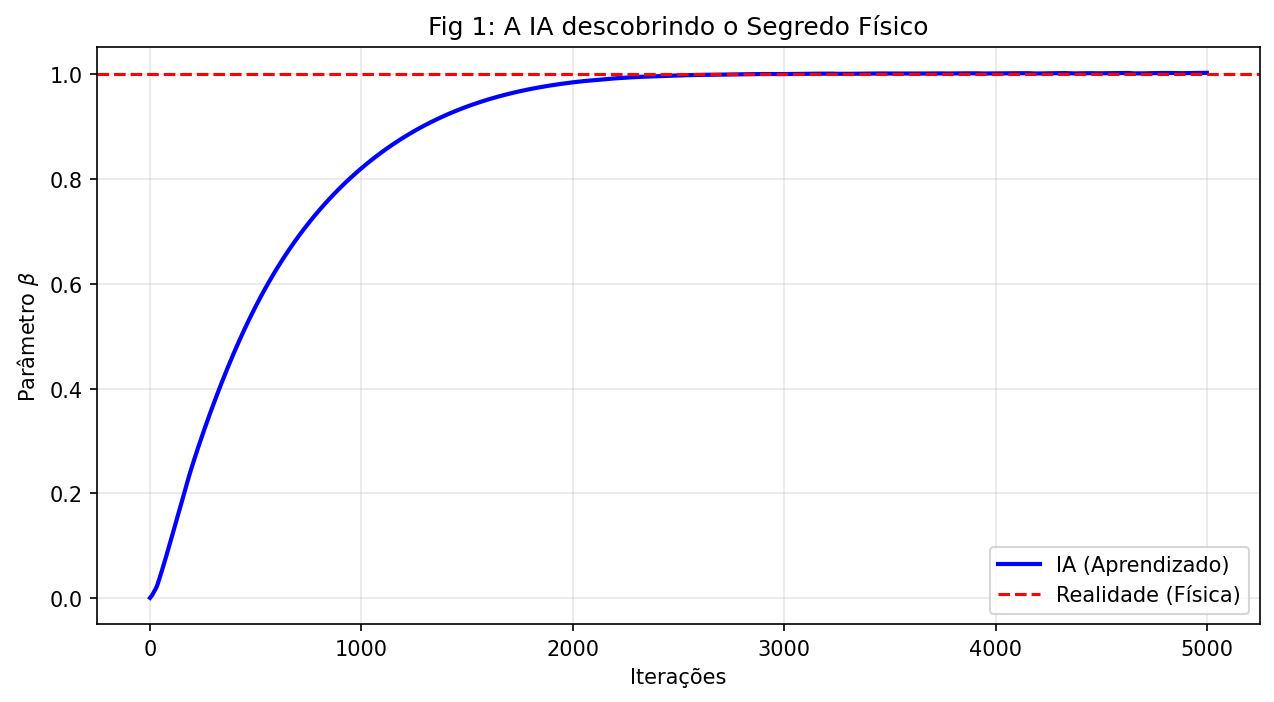

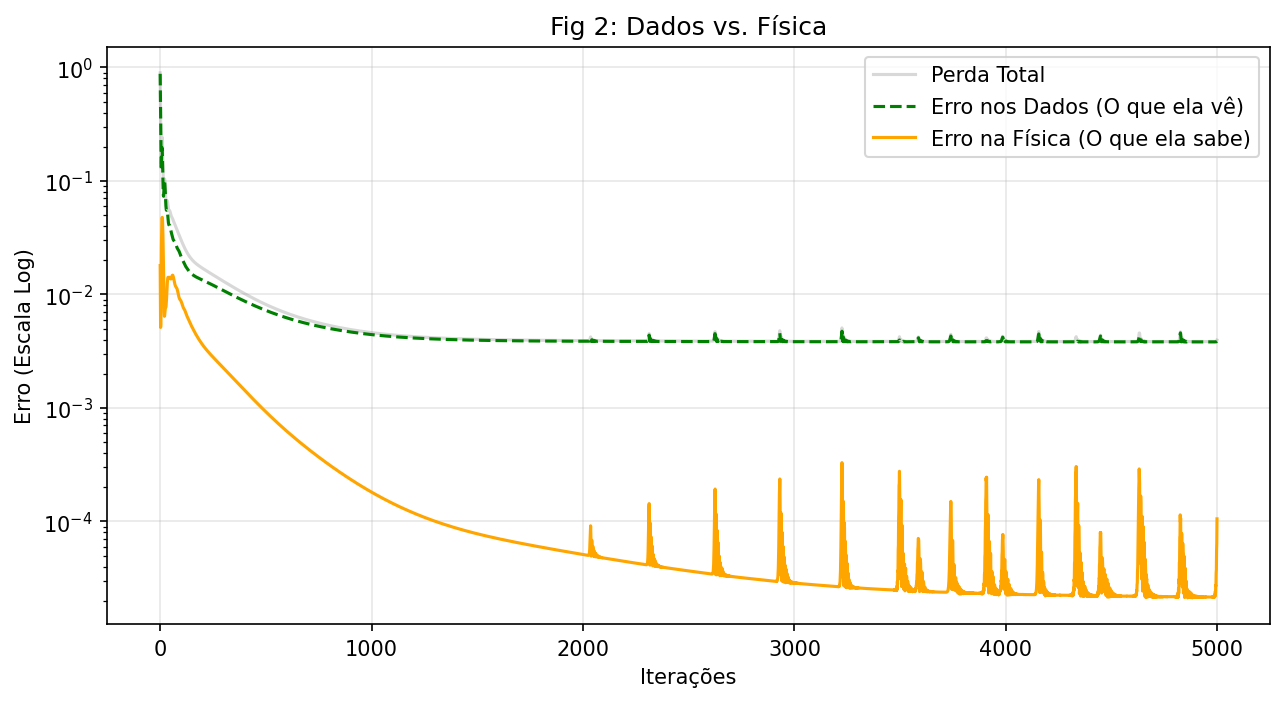

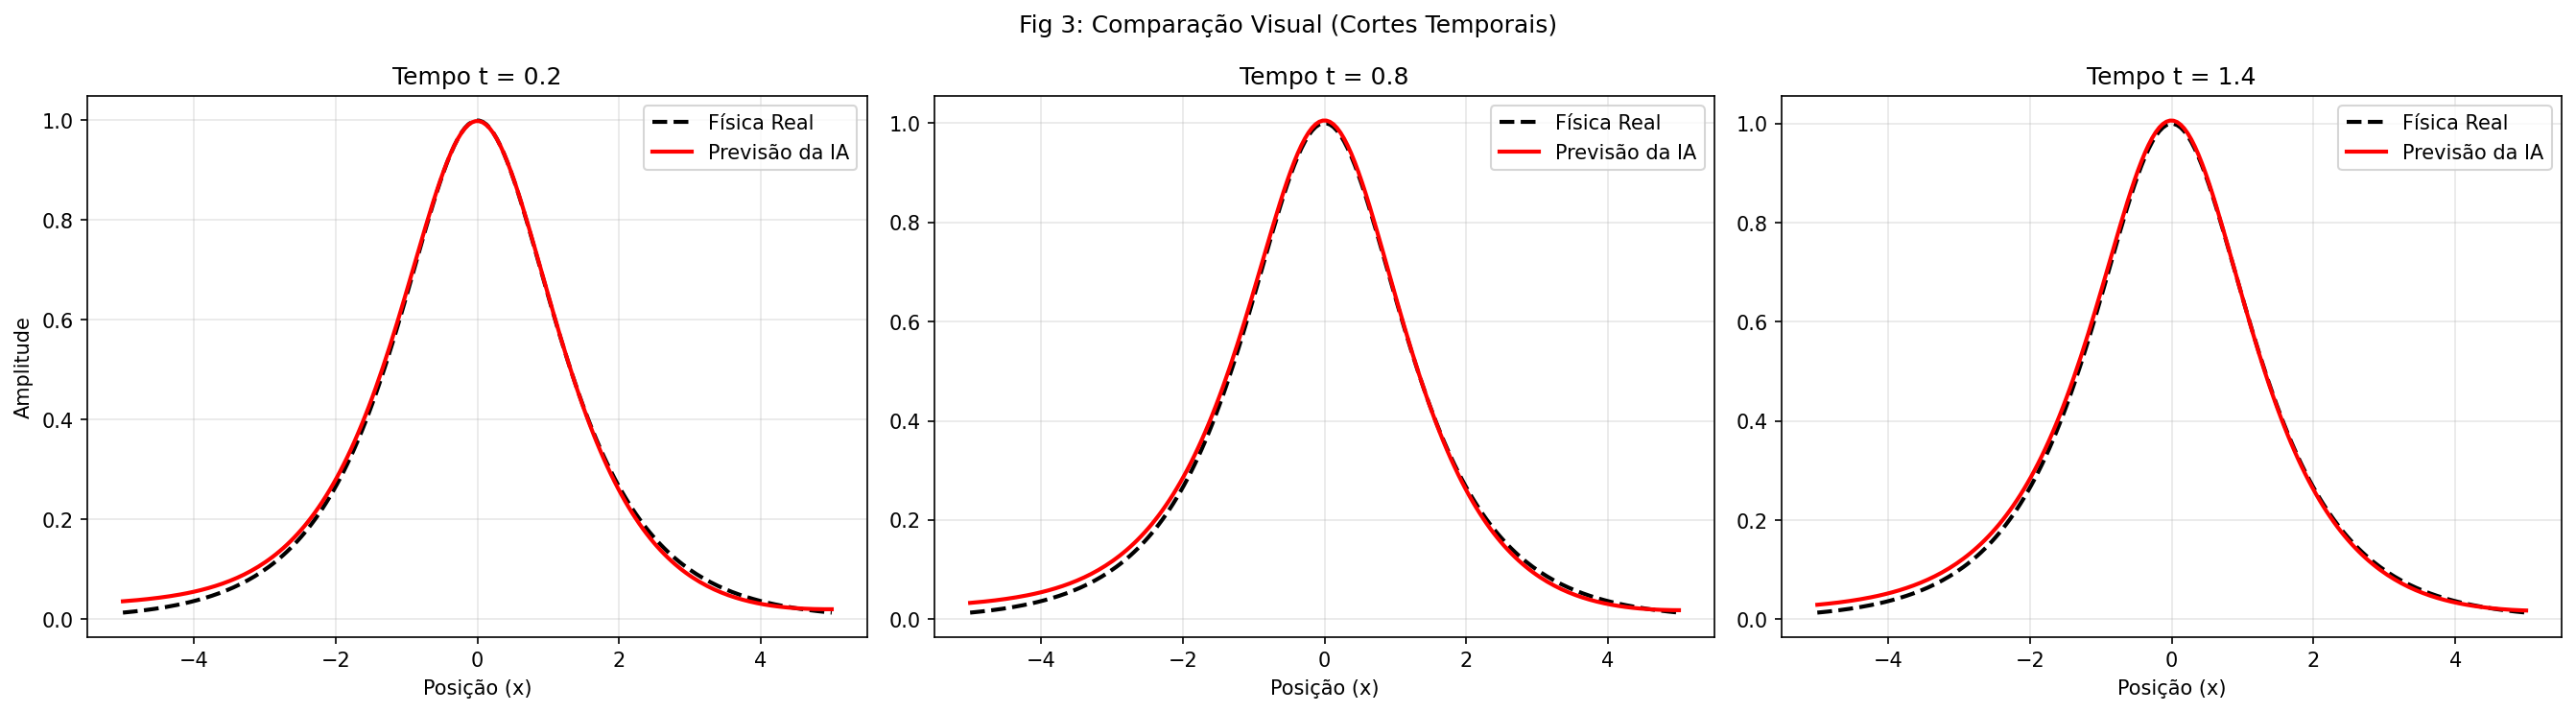

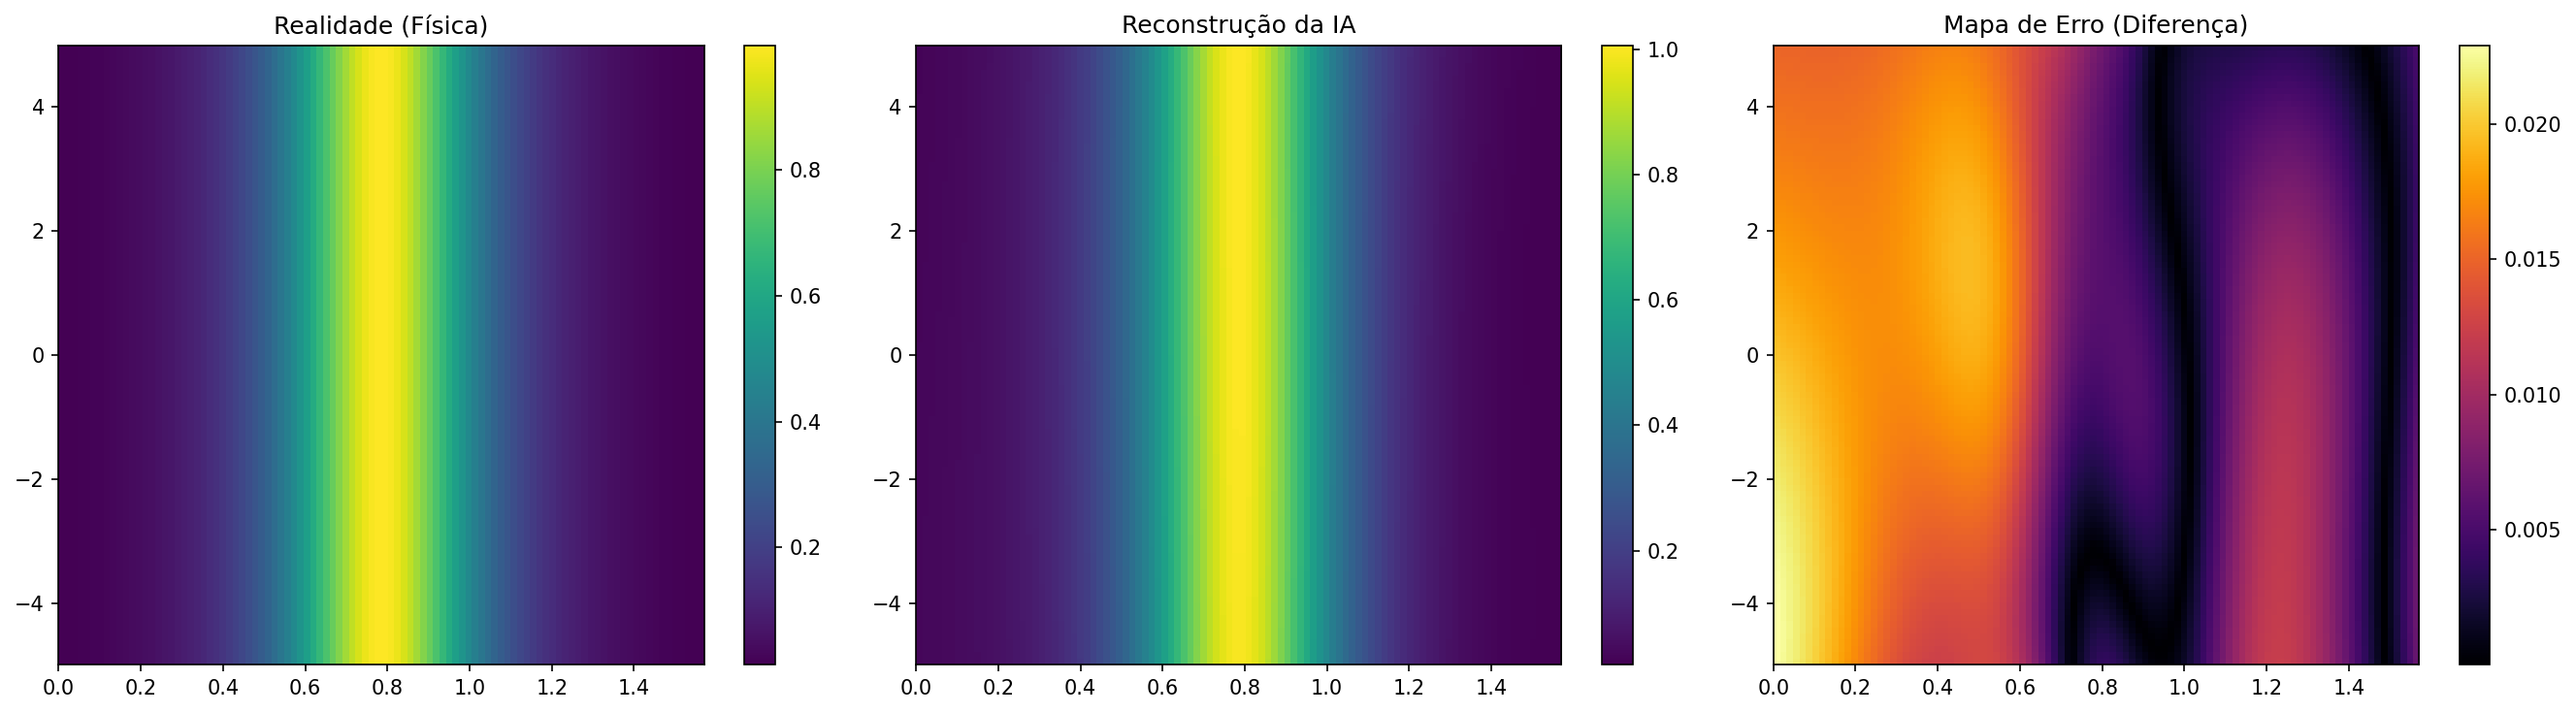

In [5]:
# --- FORÇAR A PLOTAGEM DOS GRÁFICOS ---
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1. Configurar tamanho e resolução
plt.rcParams['figure.dpi'] = 150
print("📊 Recuperando histórico e gerando gráficos...")

# --- FIGURA 1: Descoberta do Parâmetro Beta ---
plt.figure(figsize=(10, 5))
# Se o treino foi curto, a lista pode ser pequena, então plotamos o que tiver
plt.plot(trainer.history['beta'], label='IA (Aprendizado)', linewidth=2, color='blue')
plt.axhline(1.0, color='red', linestyle='--', label='Realidade (Física)')
plt.xlabel('Iterações')
plt.ylabel(r'Parâmetro $\beta$')
plt.title('Fig 1: A IA descobrindo o Segredo Físico')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- FIGURA 2: Curvas de Perda ---
plt.figure(figsize=(10, 5))
# Usamos semilogy para ver melhor a escala logarítmica
plt.semilogy(trainer.history['loss'], label='Perda Total', alpha=0.3, color='gray')
plt.semilogy(trainer.history['loss_data'], label='Erro nos Dados (O que ela vê)', linestyle='--', color='green')
plt.semilogy(trainer.history['loss_phys'], label='Erro na Física (O que ela sabe)', color='orange')
plt.xlabel('Iterações')
plt.ylabel('Erro (Escala Log)')
plt.title('Fig 2: Dados vs. Física')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- FIGURA 3: Cortes no Tempo (A Prova Real) ---
# Recalcular a grade de teste
x_range = torch.linspace(-5, 5, 200).view(-1, 1).to(device)
times_to_plot = [0.2, 0.8, 1.4] # Três momentos diferentes do "filme"

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, t_val in enumerate(times_to_plot):
    # Criar input de tempo constante
    t_test = torch.full_like(x_range, t_val).to(device)

    # Pedir para a IA prever
    u_p, v_p = model.predict(x_range, t_test)
    h_pred = np.sqrt(u_p**2 + v_p**2) # Magnitude

    # Calcular a Física Exata
    x_np = x_range.cpu().numpy()
    # Recriar a função exata localmente caso tenha perdido a referência
    psi_exact = (1.0 / np.cosh(x_np)) * np.exp(1j * 0.5 * t_val)
    h_exact = np.abs(psi_exact)

    # Plotar
    ax[i].plot(x_np, h_exact, 'k--', label='Física Real', linewidth=2)
    ax[i].plot(x_np, h_pred, 'r-', label='Previsão da IA', linewidth=2)
    ax[i].set_title(f'Tempo t = {t_val}')
    ax[i].set_xlabel('Posição (x)')
    if i == 0: ax[i].set_ylabel('Amplitude')
    ax[i].grid(True, alpha=0.3)
    ax[i].legend()

plt.suptitle('Fig 3: Comparação Visual (Cortes Temporais)')
plt.tight_layout()
plt.show()

# --- FIGURA 4: Mapa de Calor do Erro ---
# Recriar o universo completo para comparação
x_full = np.linspace(-5, 5, 100)
t_full = np.linspace(0, np.pi/2, 100)
XX, TT = np.meshgrid(x_full, t_full)
Psi_Exact = (1.0 / np.cosh(XX)) * np.exp(1j * 0.5 * TT)
H_Exact = np.abs(Psi_Exact)

# Previsão da IA no grid inteiro
x_flat = torch.tensor(XX.flatten()[:, None], dtype=torch.float32).to(device)
t_flat = torch.tensor(TT.flatten()[:, None], dtype=torch.float32).to(device)
u_flat, v_flat = model.predict(x_flat, t_flat)
H_Pred = np.sqrt(u_flat**2 + v_flat**2).reshape(XX.shape)

# Calcular erro absoluto
Erro = np.abs(H_Exact - H_Pred)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Real
c1 = ax[0].imshow(H_Exact, aspect='auto', cmap='viridis', extent=[0, 1.57, -5, 5], origin='lower')
ax[0].set_title('Realidade (Física)')
plt.colorbar(c1, ax=ax[0])

# IA
c2 = ax[1].imshow(H_Pred, aspect='auto', cmap='viridis', extent=[0, 1.57, -5, 5], origin='lower')
ax[1].set_title('Reconstrução da IA')
plt.colorbar(c2, ax=ax[1])

# Erro
c3 = ax[2].imshow(Erro, aspect='auto', cmap='inferno', extent=[0, 1.57, -5, 5], origin='lower')
ax[2].set_title('Mapa de Erro (Diferença)')
plt.colorbar(c3, ax=ax[2])

plt.tight_layout()
plt.show()

A equação fundamental que o modelo busca resolver e inferir seus parâmetros é a **Equação Não-Linear de Schrödinger (NLSE)** para a função de onda complexa $\psi(x, t)$, onde $i = \sqrt{-1}$:

$$\begin{equation}
i \frac{\partial \psi}{\partial t} + \frac{1}{2} \frac{\partial^2 \psi}{\partial x^2} + \beta |\psi|^2 \psi = 0
\end{equation}$$

Onde:
*   $\psi(x, t)$ é a função de onda complexa, que o PINN aproxima como $u(x, t) + i v(x, t)$.
*   $x$ é a variável espacial e $t$ é a variável temporal.
*   $\beta$ é o parâmetro físico não-linear que o modelo busca descobrir, representado como `self.beta_est` no código.
*   $|\psi|^2 = u^2(x, t) + v^2(x, t)$ é a densidade de probabilidade (magnitude ao quadrado).

O modelo PINN aproxima $u(x, t)$ e $v(x, t)$ a partir da sua rede neural. Para incorporar a física na função de perda, o código calcula os resíduos da NLSE, separando-a em partes real e imaginária. Se substituirmos $\psi = u + i v$ na NLSE e considerarmos $f_u$ e $f_v$ como as partes real e imaginária que devem ser zero para satisfazer a equação, temos:

$$\begin{align*}
f_u &= \frac{\partial u}{\partial t} + \frac{1}{2} \frac{\partial^2 v}{\partial x^2} + \beta v (u^2 + v^2)\\
f_v &= \frac{\partial v}{\partial t} - \frac{1}{2} \frac{\partial^2 u}{\partial x^2} - \beta u (u^2 + v^2)
\end{align*}$$

Onde $\frac{\partial}{\partial t}$ e $\frac{\partial}{\partial x}$ representam as derivadas parciais e são calculadas via diferenciação automática (`torch.autograd`).

### Função de Perda (Loss Function)

A função de perda total ($L_{total}$) que o PINN minimiza é composta por duas partes, conforme visto no código:

1.  **Perda de Dados ($L_{data}$)**: Mede o erro quadrático médio (MSE) entre as previsões da rede (`pred`) e os dados de treinamento (`u_u`, `v_u`).

    $$\begin{equation}
L_{data} = \text{MSE}(NN(x_u, t_u)_u, u_u) + \text{MSE}(NN(x_u, t_u)_v, v_u)
\end{equation}$$

2.  **Perda de Física ($L_{phys}$)**: Mede o erro quadrático médio dos resíduos da equação física ($f_u$ e $f_v$), que devem ser zero se a equação for satisfeita.

    $$\begin{equation}
L_{phys} = \text{MSE}(f_u, 0) + \text{MSE}(f_v, 0)
\end{equation}$$

A perda total é a soma dessas duas componentes:

$$\begin{equation}
L_{total} = L_{data} + L_{phys}
\end{equation}$$

Ao minimizar $L_{total}$, o PINN é forçado a aprender a partir dos dados observados e, simultaneamente, a respeitar as leis físicas governadas pela NLSE.

📊 Generating Plots for the Dissertation...


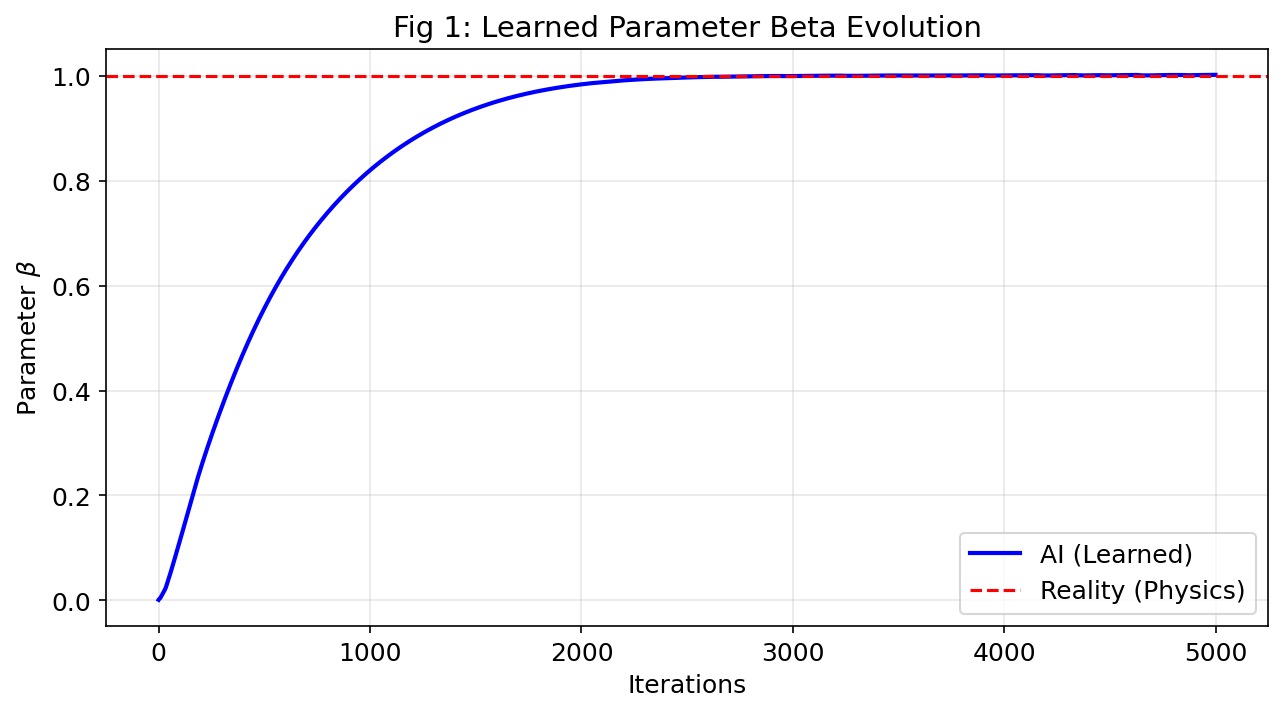

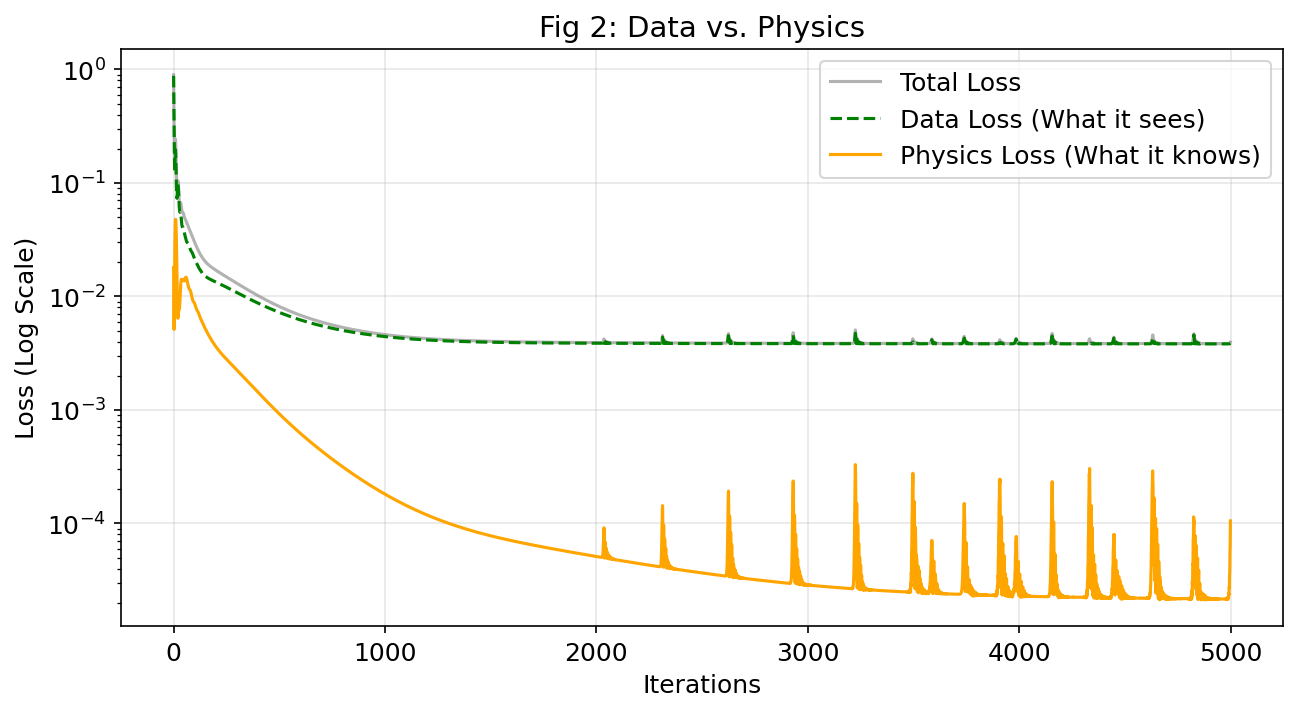

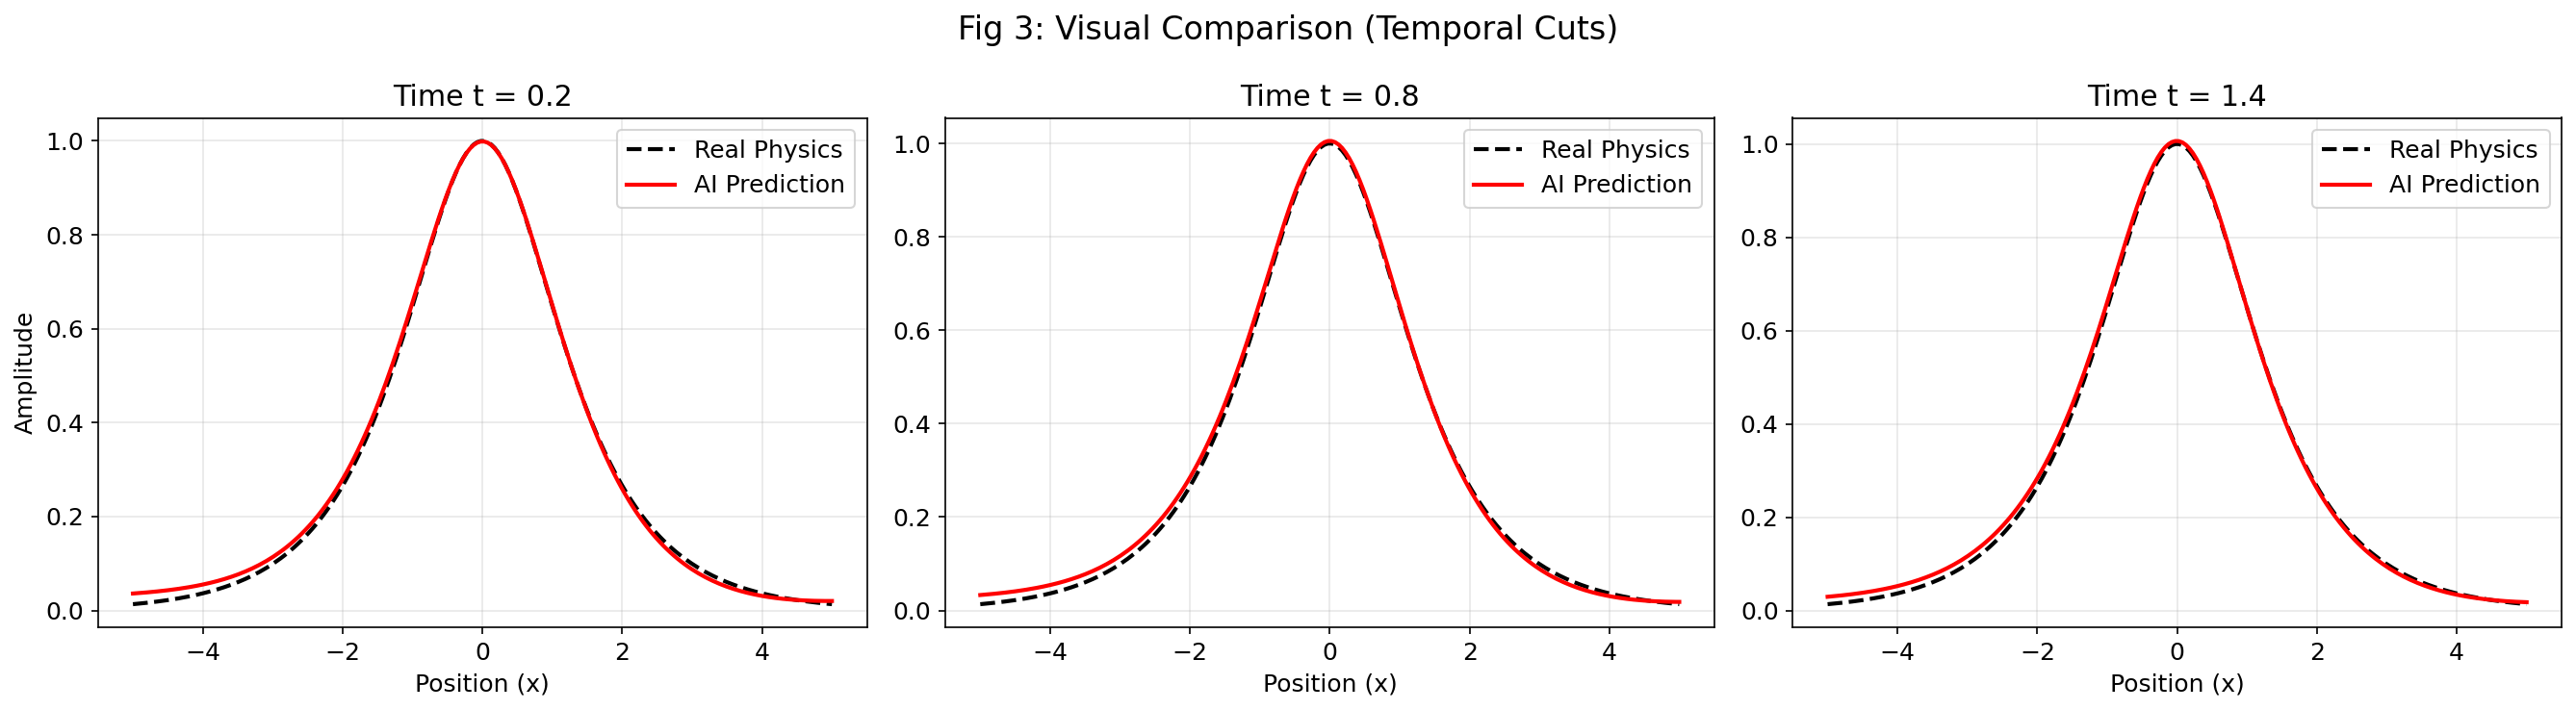

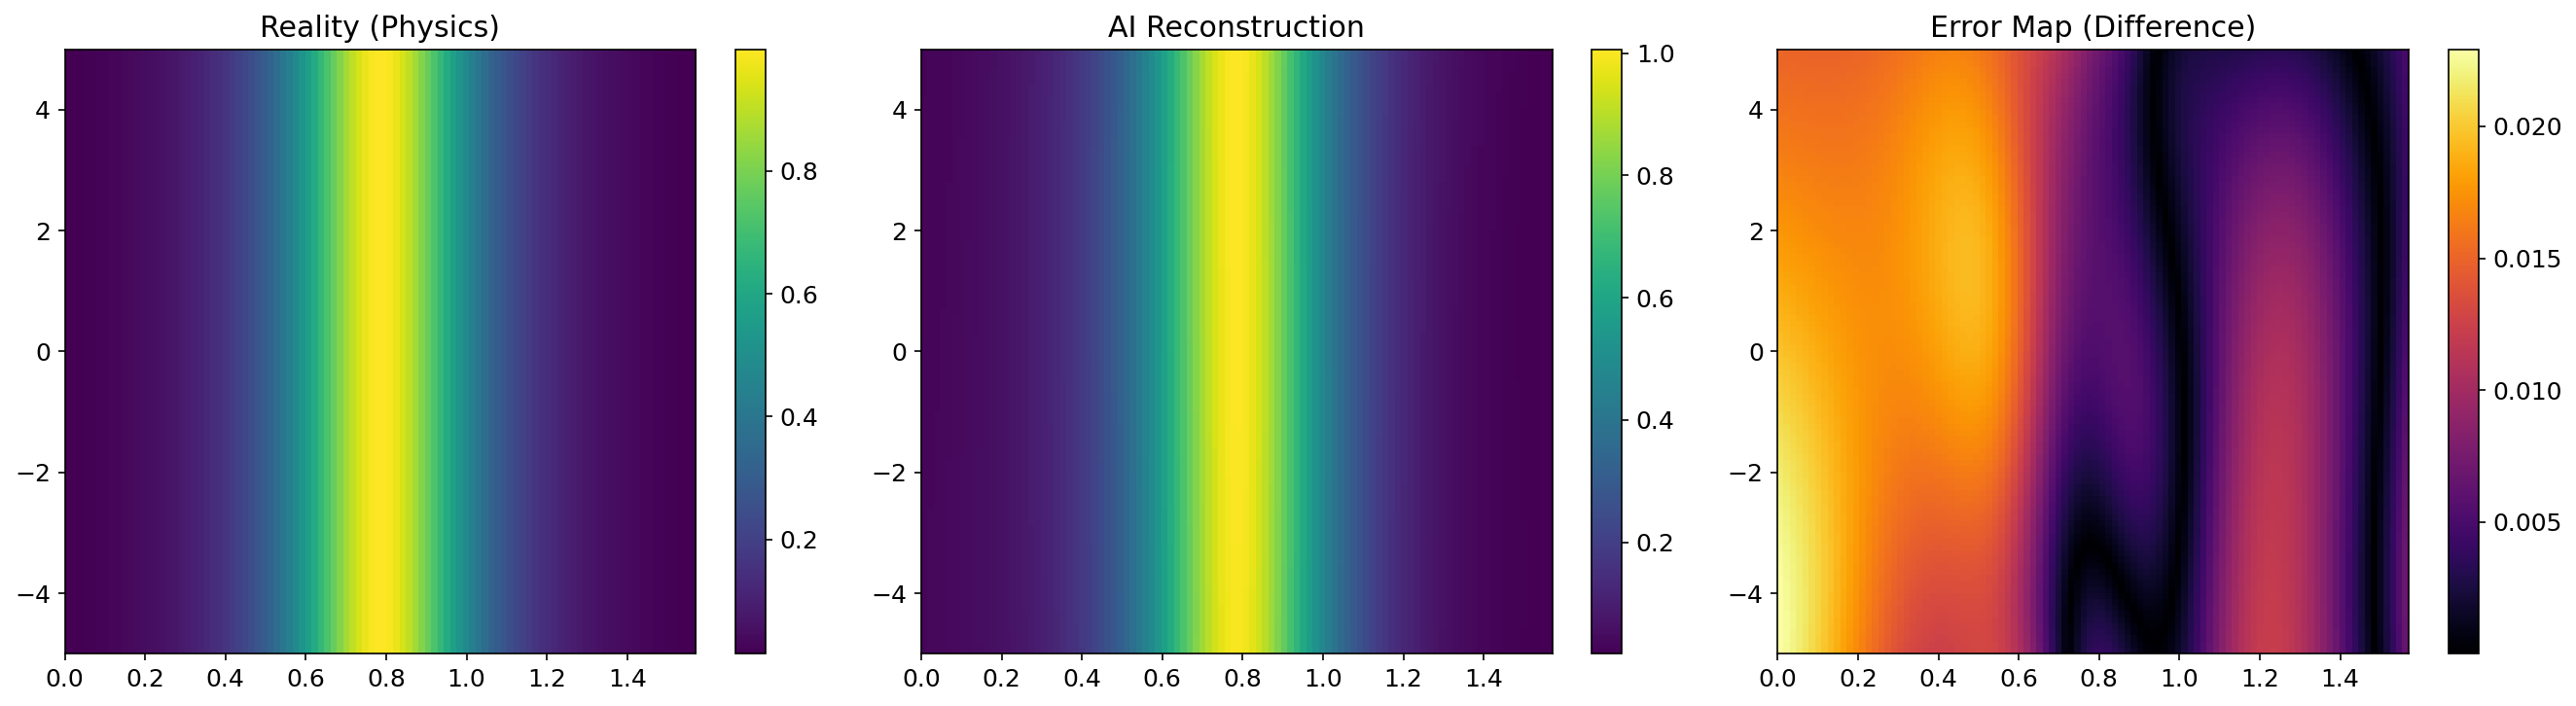

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Configure style for better appearance in the dissertation (larger fonts)
plt.rcParams.update({'font.size': 12})

print("📊 Generating Plots for the Dissertation...")

# --- FIGURE 1: Beta Parameter Discovery ---
plt.figure(figsize=(10, 5))
plt.plot(trainer.history['beta'], label='AI (Learned)', linewidth=2, color='blue')
plt.axhline(1.0, color='red', linestyle='--', label='Reality (Physics)')
plt.title('Fig 1: Learned Parameter Beta Evolution', fontsize=14)
plt.xlabel('Iterations')
plt.ylabel(r'Parameter $\beta$')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('fig1_beta_discovery.png', dpi=300, bbox_inches='tight') # Save in high resolution
plt.show()

# --- FIGURE 2: Loss Curves ---
plt.figure(figsize=(10, 5))
plt.semilogy(trainer.history['loss'], label='Total Loss', alpha=0.6, color='gray')
plt.semilogy(trainer.history['loss_data'], label='Data Loss (What it sees)', linestyle='--', color='green')
plt.semilogy(trainer.history['loss_phys'], label='Physics Loss (What it knows)', color='orange')
plt.title('Fig 2: Data vs. Physics', fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Loss (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('fig2_loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# --- FIGURE 3: Temporal Cuts (The Real Proof) ---
# Recalculate the test grid
x_range = torch.linspace(-5, 5, 200).view(-1, 1).to(device)
times_to_plot = [0.2, 0.8, 1.4] # Three different moments of the "movie"

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, t_val in enumerate(times_to_plot):
    # Create constant time input
    t_test = torch.full_like(x_range, t_val).to(device)

    # Ask AI to predict
    u_p, v_p = model.predict(x_range, t_test)
    h_pred = np.sqrt(u_p**2 + v_p**2) # Magnitude

    # Calculate Exact Physics
    x_np = x_range.cpu().numpy()
    # Recreate the exact function locally in case reference was lost
    psi_exact = (1.0 / np.cosh(x_np)) * np.exp(1j * 0.5 * t_val)
    h_exact = np.abs(psi_exact)

    # Plot
    ax[i].plot(x_np, h_exact, 'k--', label='Real Physics', linewidth=2)
    ax[i].plot(x_np, h_pred, 'r-', label='AI Prediction', linewidth=2)
    ax[i].set_title(f'Time t = {t_val}')
    ax[i].set_xlabel('Position (x)')
    if i == 0: ax[i].set_ylabel('Amplitude')
    ax[i].grid(True, alpha=0.3)
    ax[i].legend()

plt.suptitle('Fig 3: Visual Comparison (Temporal Cuts)', fontsize=16)
plt.tight_layout()
plt.savefig('fig3_temporal_cuts.png', dpi=300, bbox_inches='tight')
plt.show()

# --- FIGURE 4: Error Heatmap ---
# Recreate the entire universe for comparison
x_full_plot = np.linspace(-5, 5, 100)
t_full_plot = np.linspace(0, np.pi/2, 100)
XX, TT = np.meshgrid(x_full_plot, t_full_plot)
Psi_Exact = (1.0 / np.cosh(XX)) * np.exp(1j * 0.5 * TT)
H_Exact = np.abs(Psi_Exact)

# AI Prediction on the entire grid
x_flat_plot = torch.tensor(XX.flatten()[:, None], dtype=torch.float32).to(device)
t_flat_plot = torch.tensor(TT.flatten()[:, None], dtype=torch.float32).to(device)
u_flat_pred, v_flat_pred = model.predict(x_flat_plot, t_flat_plot)
H_Pred = np.sqrt(u_flat_pred**2 + v_flat_pred**2).reshape(XX.shape)

# Calculate absolute error
Erro = np.abs(H_Exact - H_Pred)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Real
c1 = ax[0].imshow(H_Exact, aspect='auto', cmap='viridis', extent=[0, np.pi/2, -5, 5], origin='lower')
ax[0].set_title('Reality (Physics)')
plt.colorbar(c1, ax=ax[0])

# AI
c2 = ax[1].imshow(H_Pred, aspect='auto', cmap='viridis', extent=[0, np.pi/2, -5, 5], origin='lower')
ax[1].set_title('AI Reconstruction')
plt.colorbar(c2, ax=ax[1])

# Error
c3 = ax[2].imshow(Erro, aspect='auto', cmap='inferno', extent=[0, np.pi/2, -5, 5], origin='lower')
ax[2].set_title('Error Map (Difference)')
plt.colorbar(c3, ax=ax[2])

plt.tight_layout()
plt.savefig('fig4_error_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
import numpy as np
import torch
import os

# Assuming 'universe', 'QuantumUniverse', 'PhysicsInformedNN', 'PINNTrainer', 'device', 'd', 'lhs', 'lb', 'ub', 'N_u', 'N_f' are defined from previous cells.

# Full exact data (from initial setup)
X_exact_full, T_exact_full, Psi_Exact_full = universe.generate_data(n_space=256, n_time=100)
x_flat_exact = X_exact_full.flatten()[:, None]
t_flat_exact = T_exact_full.flatten()[:, None]
u_flat_exact = np.real(Psi_Exact_full).flatten()[:, None]
v_flat_exact = np.imag(Psi_Exact_full).flatten()[:, None]
H_exact_full = np.abs(Psi_Exact_full).flatten()[:, None]

# Define layers for PINN, consistent with previous usage
layers = [2, 50, 50, 50, 50, 2]

# Lista de ruídos para testar
noise_levels = [0.05, 0.10, 0.20]
results = []
epochs_for_sensitivity = 5000  # TEM QUE SER 5000 para convergir igual ao seu melhor resultado # Reduced epochs for faster sensitivity analysis

print("--- INICIANDO ANÁLISE DE SENSIBILIDADE ---")

for nl in noise_levels:
    print(f"\nTestando Noise Level: {nl*100}% ")

    # 1. Regenerar dados de treinamento com este nível de ruído
    # Selecionar N_u pontos aleatórios do universo exato para serem os pontos de "observação"
    idx_u_train = np.random.choice(x_flat_exact.shape[0], N_u, replace=False)
    x_train_noisy = x_flat_exact[idx_u_train, :]
    t_train_noisy = t_flat_exact[idx_u_train, :]
    u_train_noisy = u_flat_exact[idx_u_train, :] + nl * np.std(u_flat_exact) * np.random.randn(N_u, 1)
    v_train_noisy = v_flat_exact[idx_u_train, :] + nl * np.std(v_flat_exact) * np.random.randn(N_u, 1)

    # Gerar pontos de colocação (collocation points)
    X_f_lhs = lb + (ub-lb) * lhs(2, N_f)
    x_f_collocation = X_f_lhs[:, 0:1]
    t_f_collocation = X_f_lhs[:, 1:2]

    # Tensores GPU para o treinamento deste experimento
    data_exp = (d(x_train_noisy), d(t_train_noisy), d(u_train_noisy), d(v_train_noisy), d(x_f_collocation), d(t_f_collocation))

    # 2. Re-instanciar e Treinar um NOVO Modelo para cada nível de ruído
    model_exp = PhysicsInformedNN(layers).to(device)
    optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=0.001) # Usar a LR padrão ou experimentar
    trainer_exp = PINNTrainer(model_exp, optimizer_exp)
    trainer_exp.train(epochs_for_sensitivity, data_exp) # Usar epochs reduzidos ou completos

    # 3. Pegar o Beta Final estimado
    beta_pred = model_exp.beta_est.item()
    error_beta = np.abs(beta_pred - 1.0) / 1.0 * 100

    # 4. Calcular erro L2 da reconstrução em relação ao ground truth completo
    model_exp.eval() # Colocar o modelo em modo de avaliação
    x_full_tensor = d(x_flat_exact)
    t_full_tensor = d(t_flat_exact)
    u_pred_full, v_pred_full = model_exp.predict(x_full_tensor, t_full_tensor)
    H_pred_full_exp = np.sqrt(u_pred_full**2 + v_pred_full**2)

    # RMSE da magnitude (amplitude)
    rmse_h = np.sqrt(np.mean((H_exact_full - H_pred_full_exp)**2))

    results.append((nl, beta_pred, error_beta, rmse_h))
    print(f"Resultado: Noise={nl*100}%, Beta={beta_pred:.4f}, Erro Beta={error_beta:.2f}%, RMSE H={rmse_h:.2e}")

print("\n--- TABELA FINAL PARA O LATEX ---")
print("Noise (%) | Beta Pred | Beta Error (%) | RMSE H")
for r in results:
    print(f"{r[0]*100:<9.1f} | {r[1]:<9.4f} | {r[2]:<14.4f} | {r[3]:.2e}")

--- INICIANDO ANÁLISE DE SENSIBILIDADE ---

Testando Noise Level: 5.0% 
🚀 Iniciando Treinamento (5000 épocas)...
Epoca 0: Loss Total: 1.12702 | Beta: 0.0010 (Erro: 99.90%)
Epoca 1000: Loss Total: 0.00127 | Beta: 0.7559 (Erro: 24.41%)
Epoca 2000: Loss Total: 0.00032 | Beta: 0.9517 (Erro: 4.83%)
Epoca 3000: Loss Total: 0.00027 | Beta: 0.9826 (Erro: 1.74%)
Epoca 4000: Loss Total: 0.00026 | Beta: 0.9856 (Erro: 1.44%)
✅ Treino Concluído em 54.3s
Resultado: Noise=5.0%, Beta=0.9863, Erro Beta=1.37%, RMSE H=6.42e-03

Testando Noise Level: 10.0% 
🚀 Iniciando Treinamento (5000 épocas)...
Epoca 0: Loss Total: 0.27985 | Beta: 0.0010 (Erro: 99.90%)
Epoca 1000: Loss Total: 0.00175 | Beta: 0.8001 (Erro: 19.99%)
Epoca 2000: Loss Total: 0.00119 | Beta: 0.9595 (Erro: 4.05%)
Epoca 3000: Loss Total: 0.00150 | Beta: 0.9783 (Erro: 2.17%)
Epoca 4000: Loss Total: 0.00116 | Beta: 0.9815 (Erro: 1.85%)
✅ Treino Concluído em 55.1s
Resultado: Noise=10.0%, Beta=0.9832, Erro Beta=1.68%, RMSE H=2.30e-03

Testando Noi

In [8]:
import torch
import numpy as np
import time

# --- CONFIGURAÇÃO PARA RODAR A VARREDURA DE BETAS ---
betas_para_testar = [0.5, 2.0, 5.0] # O 1.0 você já tem
resultados_beta = []

# Redefinindo a classe Universe para aceitar beta dinâmico (caso a sua seja fixa)
class QuantumUniverseDynamic:
    def __init__(self, beta_val):
        self.beta = beta_val

    def exact_solution(self, x, t):
        # A solução do soliton muda dependendo do Beta!
        # Para beta genérico, a amplitude e fase mudam.
        # Solução geral para NLSE: i u_t + 0.5 u_xx + beta |u|^2 u = 0
        # Soliton: u(x,t) = sqrt(1/beta) * sech(x) * exp(i * 0.5 * t)
        return np.sqrt(1.0/self.beta) * (1.0/np.cosh(x)) * np.exp(1j * 0.5 * t)

    def generate_data(self, n_space=256, n_time=100):
        x = np.linspace(-5, 5, n_space)
        t = np.linspace(0, np.pi/2, n_time)
        X, T = np.meshgrid(x, t)
        Psi = self.exact_solution(X, T)
        return X, T, Psi

print("--- INICIANDO SWEEP DE BETAS (MODO TURBO) ---")

for beta_target in betas_para_testar:
    print(f"\n=========================================")
    print(f"\u21ba RODANDO EXPERIMENTO PARA BETA = {beta_target}")
    print(f"=========================================")

    # 1. Gerar Universo com o Beta Novo
    univ_dynamic = QuantumUniverseDynamic(beta_target)
    X_exact, T_exact, Psi_exact = univ_dynamic.generate_data()

    # Flatten e Preparação
    x_flat = X_exact.flatten()[:, None]
    t_flat = T_exact.flatten()[:, None]
    u_flat = np.real(Psi_exact).flatten()[:, None]
    v_flat = np.imag(Psi_exact).flatten()[:, None]

    # 2. Adicionar Ruído de 20% (Cenário Difícil)
    idx = np.random.choice(x_flat.shape[0], N_u, replace=False)

    x_train = x_flat[idx,:]
    t_train = t_flat[idx,:]

    # Ruído proporcional ao desvio padrão dos dados novos
    noise_lvl = 0.20
    u_train = u_flat[idx,:] + noise_lvl * np.std(u_flat) * np.random.randn(N_u, 1)
    v_train = v_flat[idx,:] + noise_lvl * np.std(v_flat) * np.random.randn(N_u, 1)

    # Collocation Points (Mantém fixo ou gera novos)
    X_f_lhs = lb + (ub-lb)*lhs(2, N_f)
    x_f = X_f_lhs[:, 0:1]
    t_f = X_f_lhs[:, 1:2]

    # GPU Tensors
    d_x = d(x_train)
    d_t = d(t_train)
    d_u = d(u_train)
    d_v = d(v_train)
    d_f_x = d(x_f)
    d_f_t = d(t_f)

    # 3. Treinar Modelo (Resetar Pesos)
    model_sweep = PhysicsInformedNN(layers).to(device)
    # Forçar inicialização do beta em 0.0 para provar que ele aprende
    model_sweep.beta_est = torch.nn.Parameter(torch.tensor([0.0], device=device).float())

    optimizer_sweep = torch.optim.Adam(model_sweep.parameters(), lr=0.001)

    # Instantiate PINNTrainer for this experiment
    trainer_sweep = PINNTrainer(model_sweep, optimizer_sweep)

    # Loop de Treino Rápido (mas suficiente)
    epochs_sweep = 5000 # Reduced epochs for faster sweep

    start_time = time.time()
    trainer_sweep.train(epochs_sweep, (d_x, d_t, d_u, d_v, d_f_x, d_f_t))

    # 4. Coletar Resultados Finais
    beta_final = model_sweep.beta_est.item()
    erro_relativo = abs(beta_final - beta_target)/beta_target * 100
    tempo_total = time.time() - start_time

    print(f"--> FINAL PARA BETA {beta_target}: Pred={beta_final:.4f}, Erro={erro_relativo:.3f}%")

    resultados_beta.append({
        'truth': beta_target,
        'pred': beta_final,
        'error': erro_relativo,
        'epochs': epochs_sweep
    })

print("\n\n--- COPIE ISTO PARA SEU LATEX (TABELA 2) ---")
print("True Beta | Predicted | Rel Error | Epochs")
for r in resultados_beta:
    print(f"{r['truth']:<9.1f} | {r['pred']:<9.4f} | {r['error']:<8.2f}% | {r['epochs']}")
# Adicione a linha do 1.0 manualmente depois, pois você já tem.


--- INICIANDO SWEEP DE BETAS (MODO TURBO) ---

↺ RODANDO EXPERIMENTO PARA BETA = 0.5
🚀 Iniciando Treinamento (5000 épocas)...
Epoca 0: Loss Total: 1.19701 | Beta: 0.0010 (Erro: 99.90%)
Epoca 1000: Loss Total: 0.00928 | Beta: 0.4908 (Erro: 50.92%)
Epoca 2000: Loss Total: 0.00915 | Beta: 0.5035 (Erro: 49.65%)
Epoca 3000: Loss Total: 0.00908 | Beta: 0.5040 (Erro: 49.60%)
Epoca 4000: Loss Total: 0.00904 | Beta: 0.5049 (Erro: 49.51%)
✅ Treino Concluído em 55.2s
--> FINAL PARA BETA 0.5: Pred=0.5055, Erro=1.091%

↺ RODANDO EXPERIMENTO PARA BETA = 2.0
🚀 Iniciando Treinamento (5000 épocas)...
Epoca 0: Loss Total: 0.44590 | Beta: 0.0010 (Erro: 99.90%)
Epoca 1000: Loss Total: 0.00406 | Beta: 1.1113 (Erro: 11.13%)
Epoca 2000: Loss Total: 0.00249 | Beta: 1.6623 (Erro: 66.23%)
Epoca 3000: Loss Total: 0.00227 | Beta: 1.9129 (Erro: 91.29%)
Epoca 4000: Loss Total: 0.00224 | Beta: 1.9877 (Erro: 98.77%)
✅ Treino Concluído em 54.4s
--> FINAL PARA BETA 2.0: Pred=2.0005, Erro=0.024%

↺ RODANDO EXPERIMENTO P

In [9]:
import torch
import torch.nn as nn
import numpy as np
import time
from pyDOE import lhs

# --- CONFIGURAÇÕES ---
SEEDS = [42, 123, 999]      # 3 Runs independentes
EPOCHS = 15000              # Reduzido levemente para caber no tempo, mas suficiente
N_f = 15000                 # Pontos de colocação

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Iniciando Super Run no dispositivo: {device}")

# --- CLASSE PINN ---
class PhysicsInformedNN(nn.Module):
    def __init__(self, layers):
        super(PhysicsInformedNN, self).__init__()
        self.beta_est = nn.Parameter(torch.tensor([0.0], device=device).float())
        self.weights = nn.ParameterList()
        self.biases = nn.ParameterList()
        for i in range(len(layers)-1):
            w = nn.Parameter(torch.zeros(layers[i], layers[i+1]).to(device))
            b = nn.Parameter(torch.zeros(1, layers[i+1]).to(device))
            nn.init.xavier_normal_(w)
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, x, t):
        X = torch.cat([x, t], 1)
        for i in range(len(self.weights)-1):
            X = torch.tanh(torch.addmm(self.biases[i], X, self.weights[i]))
        U = torch.addmm(self.biases[-1], X, self.weights[-1])
        return U[:, 0:1], U[:, 1:2]

    def physics_loss(self, x, t):
        u, v = self.forward(x, t)
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]
        f_u = u_t + 0.5*v_xx + self.beta_est * (u**2 + v**2) * v
        f_v = v_t - 0.5*u_xx - self.beta_est * (u**2 + v**2) * u
        return f_u, f_v

def exact_solution(x, t, beta):
    return np.sqrt(1.0/beta) * (1.0/np.cosh(x)) * np.exp(1j * 0.5 * t)

# --- FUNÇÃO DE TREINO GENÉRICA ---
def run_experiment(beta_true, n_data, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Gerar Dados
    x = np.linspace(-5, 5, 256)
    t = np.linspace(0, np.pi/2, 100)
    X, T = np.meshgrid(x, t)
    Psi = exact_solution(X, T, beta_true)

    x_flat = X.flatten()[:, None]
    t_flat = T.flatten()[:, None]
    u_flat = np.real(Psi).flatten()[:, None]
    v_flat = np.imag(Psi).flatten()[:, None]

    # Seleção Esparsa
    idx = np.random.choice(x_flat.shape[0], n_data, replace=False)

    # Ruído 20%
    u_train = u_flat[idx,:] + 0.20 * np.std(u_flat) * np.random.randn(n_data, 1)
    v_train = v_flat[idx,:] + 0.20 * np.std(v_flat) * np.random.randn(n_data, 1)

    # Collocation
    lb = np.array([-5.0, 0.0])
    ub = np.array([5.0, np.pi/2])
    X_f = lb + (ub-lb)*lhs(2, N_f)

    # Tensors
    pt_x = torch.tensor(x_flat[idx,:], dtype=torch.float32, device=device)
    pt_t = torch.tensor(t_flat[idx,:], dtype=torch.float32, device=device)
    pt_u = torch.tensor(u_train, dtype=torch.float32, device=device)
    pt_v = torch.tensor(v_train, dtype=torch.float32, device=device)
    pt_xf = torch.tensor(X_f[:, 0:1], dtype=torch.float32, device=device, requires_grad=True)
    pt_tf = torch.tensor(X_f[:, 1:2], dtype=torch.float32, device=device, requires_grad=True)

    # Treino
    model = PhysicsInformedNN([2, 50, 50, 50, 50, 2]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(EPOCHS):
        model.train()
        optimizer.zero_grad()
        u_p, v_p = model(pt_x, pt_t)
        loss_d = torch.mean((u_p - pt_u)**2 + (v_p - pt_v)**2)
        fu, fv = model.physics_loss(pt_xf, pt_tf)
        loss_p = torch.mean(fu**2 + fv**2)
        loss = loss_d + loss_p
        loss.backward()
        optimizer.step()

    beta_pred = model.beta_est.item()
    err = abs(beta_pred - beta_true)/beta_true * 100
    return beta_pred, err

# --- EXECUÇÃO 1: VARREDURA DE BETA (Beta Sweep) ---
print("\n--- INICIANDO BETA SWEEP (N_u=500 fixo) ---")
betas = [0.5, 1.0, 2.0, 5.0]
beta_results = {}

for b in betas:
    errs = []
    print(f"Testing Beta={b}...")
    for s in SEEDS:
        _, err = run_experiment(beta_true=b, n_data=500, seed=s)
        errs.append(err)
        print(f"   Seed {s}: Error {err:.3f}%")
    beta_results[b] = (np.mean(errs), np.std(errs))

# --- EXECUÇÃO 2: VARREDURA DE DADOS (Data Sweep) ---
print("\n--- INICIANDO DATA SWEEP (Beta=1.0 fixo) ---")
data_points = [100, 250, 500, 1000]
data_results = {}

for n in data_points:
    errs = []
    print(f"Testing N_u={n}...")
    for s in SEEDS:
        _, err = run_experiment(beta_true=1.0, n_data=n, seed=s)
        errs.append(err)
        print(f"   Seed {s}: Error {err:.3f}%")
    data_results[n] = (np.mean(errs), np.std(errs))

# --- IMPRESSÃO DAS TABELAS ---
print("\n\n=== TABELA 2: BETA SENSITIVITY ===")
print("Beta | Mean Error (%) | Std Dev")
for b, (m, s) in beta_results.items():
    print(f"{b:<4} | {m:.3f}          | {s:.3f}")

print("\n\n=== TABELA 3: DATA SENSITIVITY ===")
print("N_u  | Mean Error (%) | Std Dev")
for n, (m, s) in data_results.items():
    print(f"{n:<4} | {m:.3f}          | {s:.3f}")

🚀 Iniciando Super Run no dispositivo: cuda

--- INICIANDO BETA SWEEP (N_u=500 fixo) ---
Testing Beta=0.5...
   Seed 42: Error 0.074%
   Seed 123: Error 0.902%
   Seed 999: Error 0.001%
Testing Beta=1.0...
   Seed 42: Error 0.020%
   Seed 123: Error 0.972%
   Seed 999: Error 0.092%
Testing Beta=2.0...
   Seed 42: Error 0.017%
   Seed 123: Error 1.058%
   Seed 999: Error 0.165%
Testing Beta=5.0...
   Seed 42: Error 0.180%
   Seed 123: Error 1.159%
   Seed 999: Error 0.322%

--- INICIANDO DATA SWEEP (Beta=1.0 fixo) ---
Testing N_u=100...
   Seed 42: Error 0.343%
   Seed 123: Error 1.536%
   Seed 999: Error 2.538%
Testing N_u=250...
   Seed 42: Error 3.165%
   Seed 123: Error 1.406%
   Seed 999: Error 0.191%
Testing N_u=500...
   Seed 42: Error 0.020%
   Seed 123: Error 0.972%
   Seed 999: Error 0.092%
Testing N_u=1000...
   Seed 42: Error 0.638%
   Seed 123: Error 1.663%
   Seed 999: Error 0.110%


=== TABELA 2: BETA SENSITIVITY ===
Beta | Mean Error (%) | Std Dev
0.5  | 0.326          | 